---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Pratham Kabra
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-13-04"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [2]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/lab08-PrathamKabra/data/lightcast_job_postings.csv")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

#df.printSchema() # comment this line when rendering the submission
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/14 22:38:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [3]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows with missing values in required columns
df = df.dropna(subset=["SALARY", "SALARY_TO", "SALARY_FROM", "DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME", "CITY_NAME", "MIN_EDULEVELS", "MAX_YEARS_EXPERIENCE"])



# Define categorical and numerical columns
categorical_cols = ["CITY_NAME"]
numerical_cols = ["MIN_EDULEVELS", "MAX_YEARS_EXPERIENCE"]

# Create indexers and encoders for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build and fit the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df)

# Preview the result
data.select("SALARY", "features").show(5, truncate=False)


+------+-----------------------------+
|SALARY|features                     |
+------+-----------------------------+
|131100|(246,[0,1,18],[2.0,2.0,1.0]) |
|136950|(246,[0,1,239],[2.0,3.0,1.0])|
|136950|(246,[0,1,56],[2.0,3.0,1.0]) |
|104000|(246,[0,1,8],[2.0,3.0,1.0])  |
|80000 |(246,[0,1,52],[2.0,3.0,1.0]) |
+------+-----------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [4]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.7, 0.3], seed=957)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

25/04/14 22:39:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(388, 134)


(166, 134)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Drop the 'features' column if it already exists
train_data = train_data.drop("features")
test_data = test_data.drop("features")

# Prepare the data
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="SALARY", regParam=0.1)
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using R², RMSE, and MAE
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

# Print the performance metrics
print("\n---- Model Performance on Test Data ----")
print(f"R² Value: {r2:.4f}")
print(f"RMSE Value: {rmse:.2f}")
print(f"MAE Value: {mae:.2f}")

# Get the model summary
summary = lr_model.summary

# Extract coefficients and other statistical details
coefficients = summary.coefficients.toArray()  # Correct way to access the coefficients
intercept = summary.intercept  # Intercept is a single value
t_values = summary.tValues[1:]  # Skip the first value (intercept)
p_values = summary.pValues[1:]  # Skip the first value (intercept)
std_errors = summary.coefficientStandardErrors[1:]  # Skip the first value (intercept)

# Prepare a DataFrame to display the results
results_df = pd.DataFrame({
    'Feature': flat_feature_names, 
    'Coefficient': coefficients,
    'Standard Error': std_errors,
    't-value': t_values,
    'p-value': p_values
})

# Display the DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Coefficients and Statistics", dataframe=results_df)

# Print the coefficients, standard errors, t-values, and p-values
print("\n---- Model Coefficients and Statistical Results ----")
print(results_df)



---- Model Performance on Test Data ----
R² Value: 0.0728
RMSE Value: 31862.91
MAE Value: 23959.34


AttributeError: 'LinearRegressionTrainingSummary' object has no attribute 'coefficients'

In [31]:
# Get the model summary
summary = lr_model.summary

# Extract coefficients and other statistical details
coefficients = summary.coefficients.toArray()  # Convert DenseVector to a numpy array
intercept = summary.intercept  # Intercept is a single value
t_values = summary.tValues[1:]  # Skip the first value (intercept)
p_values = summary.pValues[1:]  # Skip the first value (intercept)
std_errors = summary.coefficientStandardErrors[1:]  # Skip the first value (intercept)

# Prepare a DataFrame to display the results
results_df = pd.DataFrame({
    'Feature': flat_feature_names,  # Ensure this matches the number of features
    'Coefficient': coefficients,
    'Standard Error': std_errors,
    't-value': t_values,
    'p-value': p_values
})

# Display the DataFrame
import ace_tools as tools; tools.display_dataframe_to_user


AttributeError: 'LinearRegressionTrainingSummary' object has no attribute 'coefficients'

In [27]:
print(len(flat_feature_names))  # Should match the number of coefficients and features
print(len(coefficients))  # Should match the number of coefficients


246


NameError: name 'coefficients' is not defined

In [11]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)


IllegalArgumentException: Output column features already exists.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [6]:
metadata = data.schema["features"].metadata["ml_attr"]["attrs"]

# Flatten it safely into a list
flat_feature_names = []
for key in metadata:  # Usually 'numeric' and 'binary'
    flat_feature_names += [attr["name"] for attr in metadata[key]]
print(" Confirmed corrected length:", len(flat_feature_names))


 Confirmed corrected length: 246


In [7]:
from tabulate import tabulate
df_summary = pd.DataFrame({
    "Feature": flat_feature_names,
    "Coefficient": list(lr_model.coefficients),
    "Std Error": list(summary.coefficientStandardErrors)[:len(flat_feature_names)],
    "T-Value": list(summary.tValues)[:len(flat_feature_names)],
    "P-Value": list(summary.pValues)[:len(flat_feature_names)]
})

z = 1.96  # 95% CI
df_summary["CI Lower"] = df_summary["Coefficient"] - z * df_summary["Std Error"]
df_summary["CI Upper"] = df_summary["Coefficient"] + z * df_summary["Std Error"]


print(tabulate(df_summary, headers="keys", tablefmt="pretty"))



+-----+---------------------------------------+---------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+
|     |                Feature                |     Coefficient     |     Std Error      |        T-Value        |       P-Value        |      CI Lower       |      CI Upper      |
+-----+---------------------------------------+---------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+
|  0  |             MIN_EDULEVELS             |  16.0486948601509   | 61.17671990617387  |  0.2623333661033907   |  0.7934473229633843  | -103.85767615594989 | 135.9550658762517  |
|  1  |         MAX_YEARS_EXPERIENCE          |  9962.67956700743   | 900.9306035270284  |  11.058209731143341   |         0.0          |  8196.855584094454  | 11728.503549920406 |
|  2  |      CITY_NAME_vec_New York, NY       | 26001.340755085985  | 30616.76067672793  |   0.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


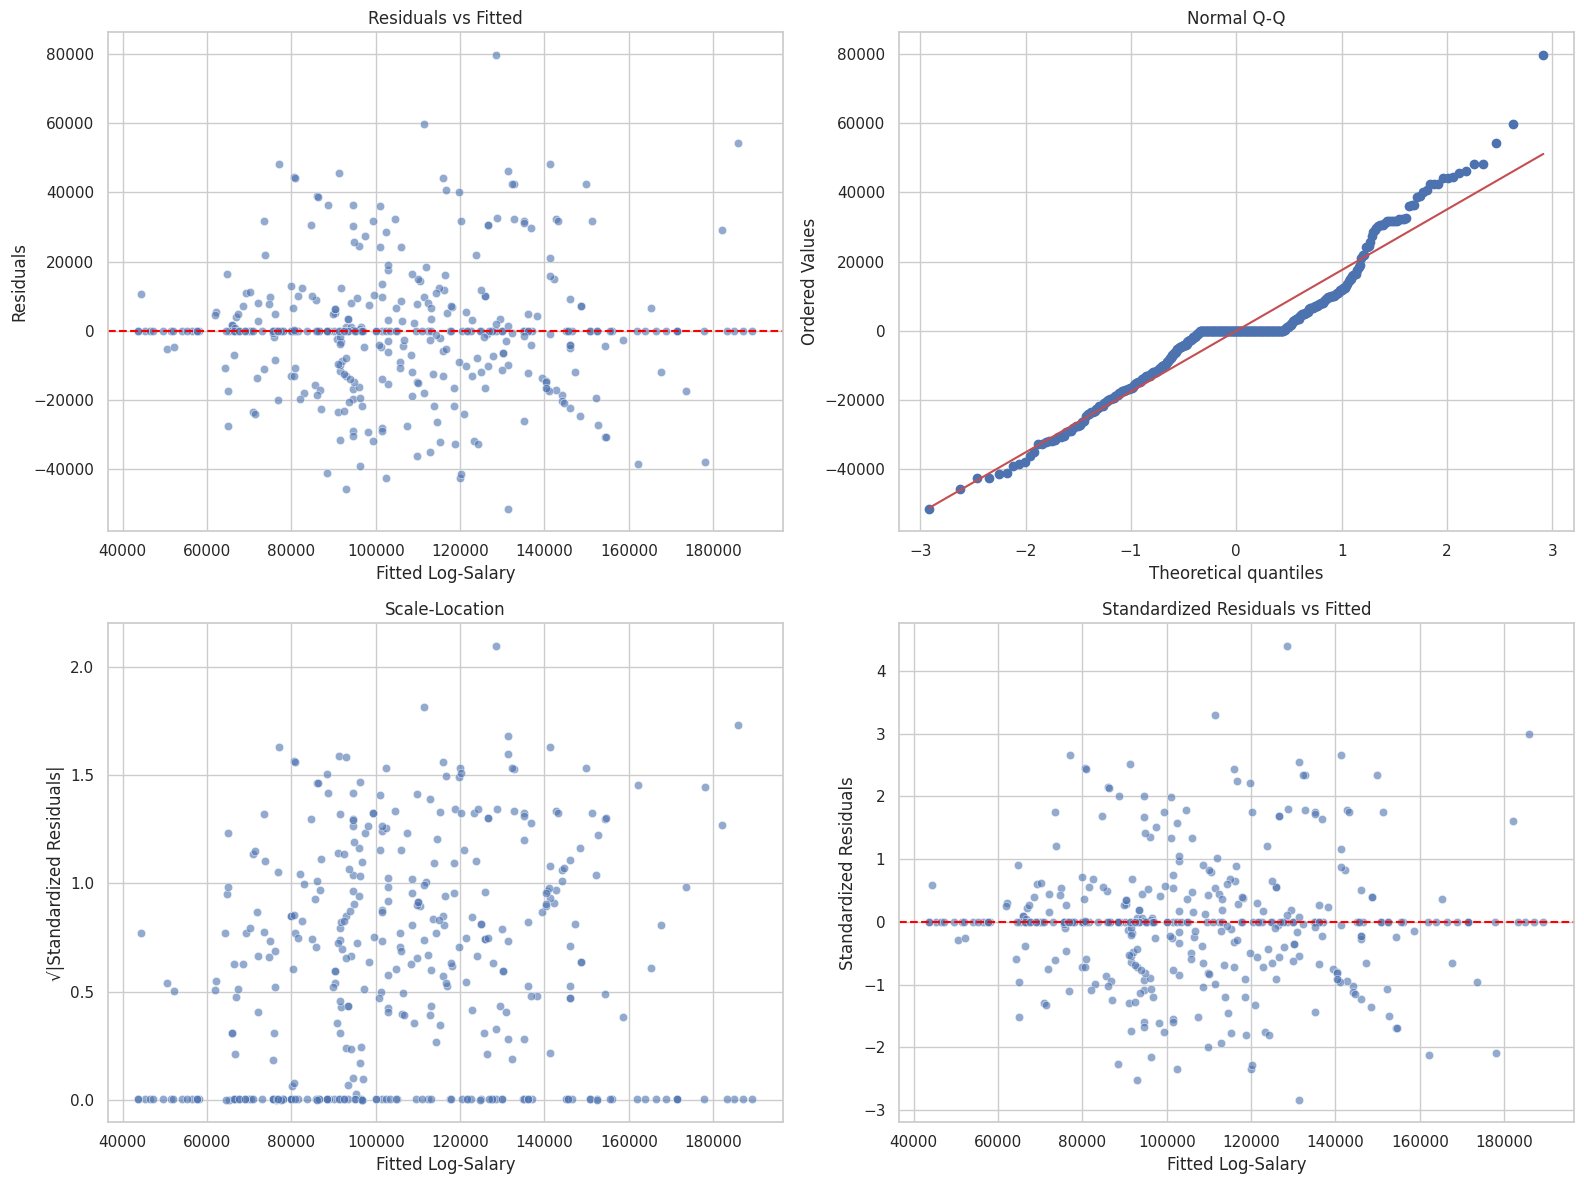

In [8]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Convert predictions to pandas
df_pred = summary.predictions.select("prediction", "SALARY").toPandas()

# Residuals and fitted values
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Plot layout
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# 1. Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Residuals")

# 2. Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# 3. Scale-Location Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred, alpha=0.6)
plt.title("Scale-Location")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("√|Standardized Residuals|")

# 4. Standardized Residuals vs Fitted
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Standardized Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Standardized Residuals")

# Output
plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Predict on test set
pred_glr = lr_model.transform(test_data)

# 1. R² Evaluation
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# 2. BIC Calculation
n = pred_glr.count()
k = len(lr_model.coefficients)
rss = pred_glr.select(pow(col("SALARY") - col("prediction"), 2).alias("squared_error")) \
              .agg({"squared_error": "sum"}).collect()[0][0]
bic = n * np.log(rss / n) + k * np.log(n)

# 3. RMSE (manual)
rmse = np.sqrt(rss / n)

# 4. Print Evaluation Summary
print("\n--- Model Evaluation on SALARY ---")
print(f"R²     : {r2:.4f}")
print(f"RMSE   : {rmse:.4f}")




--- Model Evaluation on SALARY ---
R²     : 0.0728
RMSE   : 31862.9074


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

/home/ubuntu/lab08-PrathamKabra/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in expm1

/home/ubuntu/lab08-PrathamKabra/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in expm1



Index(['prediction', 'SALARY', 'actual_salary', 'predicted_salary'], dtype='object')


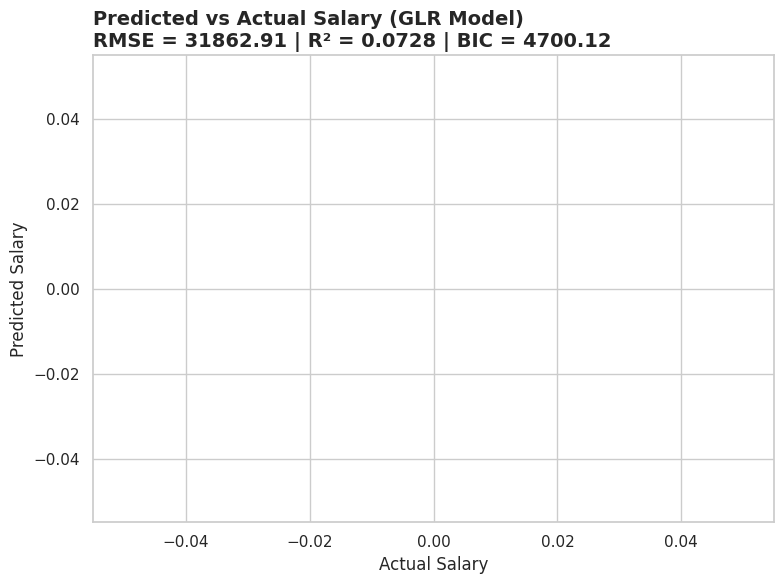

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert predictions to pandas
pandas_df = pred_glr.select("prediction", "SALARY").toPandas()

pandas_df["actual_salary"] = np.expm1(pandas_df["SALARY"])
pandas_df["predicted_salary"] = np.expm1(pandas_df["prediction"])


print(pandas_df.columns)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="actual_salary", y="predicted_salary", data=pandas_df, alpha=0.6)

# Reference line
plt.plot([pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         [pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         color="red", linestyle="--")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | BIC = {bic:.2f}", 
          loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
